In [45]:
import geopandas as panda
import pandas as p
data = panda.read_file("datapbl_pgh.csv")
data.head()


,report_id,vehicle_type,vehicle_movement,plate_state,created_at_local,created_at_epoch,address,latitude,longitude,geometry
0,21645,Other,standing,PA,2019-10-16T08:18:48,1571228328000,"4609 Forbes Ave, Pittsburgh, PA 15213",40.44459444444444,-79.94809722222223,None
1,21734,Private,standing,PA,2019-10-16T17:15:58,1571260558000,"305 Wood St, Pittsburgh, PA 15222",40.4389424,-80.0016382,None
2,21640,Other,parked,PA,2019-10-16T08:02:54,1571227374000,"4615 Forbes Ave, Pittsburgh, PA 15213",40.44456944444444,-79.94785277777778,None
3,21641,Other,standing,US,2019-10-16T12:16:42,1571242602000,"30 Foster Sq, Pittsburgh, PA 15212",40.4511631,-80.0073019,None
4,21608,Private,Loading,PA,2019-10-16T08:16:14,1571228174000,"6 PPG Pl, Pittsburgh, PA 15222",40.4397019,-80.0036409,None


Source: https://data.wprdc.org/dataset/shape-files-for-bikepgh-s-pittsburgh-bike-map (August 2019 protected bike lanes)

This Data gives us the longitude and latitude of each of vehicle blocking a bike lane, but to find the neighborhoods they are in, we will need to use a neighborhood data set that gives us the polygons enclosing each neighborhood

for each neighborhood, I will give it a score on bike lane blockages. Standing and loading vehicles will give it +1 and parked vehicles will give it +2

I figured since a loading or standing car usually has a person attending it and ready to move it soon, those were not as bad as a parked car, where the driver may be gone for any amount of time


In [48]:

neighborData = panda.read_file("Neighborhoods_.shp")
neighborData.head()


,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
0,1,233,42,003,140500,3,420031405003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7968760.0,a642a6b6-a2a9-48d5-acf2-3e2ce87d4bc0,8.153647e+06,14047.065024,"POLYGON ((-79.90560 40.45522, -79.90553 40.455..."
1,2,203,42,003,140100,3,420031401003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,34078712.0,20d4605b-258e-441a-a57e-a28fdabb6d30,3.407739e+07,30347.886823,"POLYGON ((-79.91309 40.43804, -79.91321 40.438..."
2,3,86,42,003,101700,2,420031017002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12751163.0,bf4065e7-c29c-48bd-b529-e7fd99077238,1.275116e+07,14577.441571,"POLYGON ((-79.93457 40.47217, -79.93455 40.472..."
3,4,214,42,003,050900,1,420030509001,Block Group 1,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,4997335.5,fed3fb32-0cd3-4556-aa41-17ee03b4fe41,4.997845e+06,14216.959213,"POLYGON ((-79.96601 40.45520, -79.96596 40.454..."
4,5,173,42,003,300100,5,420033001005,Block Group 5,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,8411048.0,8669d2f0-b886-4519-99d0-bb1015b592b0,8.410563e+06,12003.269761,"POLYGON ((-79.98845 40.41851, -79.98821 40.418..."


This data gives us the longitude and lattitude of the different neighborhoods.


In [56]:
neighborhoods = p.DataFrame(columns = ["Neighborhood", "Geometry", "Bike Lane Violation Score"])
neighborhoods["Neighborhood"] = neighborData["hood"]
neighborhoods["Geometry"] = neighborData["geometry"]
neighborhoods["Bike Lane Violation Score"] = 0
neighborhoods["Total Violations"] = 0
neighborhoods["Total Parked"] = 0
neighborhoods["Total Standing"] = 0
neighborhoods["Total Loading"] = 0

neighborhoods.head(3)

,Neighborhood,Geometry,Bike Lane Violation Score,Total Violations,Total Parked,Total Standing,Total Loading
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0,0,0,0,0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",0,0,0,0,0
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",0,0,0,0,0


Now that we have the Polygon data, but we need to add the bike lane vil

In [57]:
from shapely.geometry import Point 

##print(bikeData.iterrows().size())
for i, datum in data.iterrows(): #iterate through the bike lane violations
    pt = Point(float(datum["longitude"]), float(datum["latitude"]))
    violationType = datum["vehicle_movement"]
    for j, hood in neighborhoods.iterrows(): ##finding the neighborhood that this violation is in
        if hood["Geometry"].contains(pt): ##if the current neighborhood contains the point, then its the one our violation is in
            if violationType == "parked": ## for parked we add +2
                neighborhoods.at[j,"Bike Lane Violation Score"] +=2
                neighborhoods.at[j,"Total Parked"] +=1
            else: ## for other violations we add +1
                neighborhoods.at[j,"Bike Lane Violation Score"] +=1
                if violationType == "standing":
                    neighborhoods.at[j,"Total Standing"] +=1
                else:
                    neighborhoods.at[j,"Total Loading"] +=1
            neighborhoods.at[j,"Total Violations"] +=1
            break # we found the neighborhood so we can break out of this loop
neighborhoods.head()

,Neighborhood,Geometry,Bike Lane Violation Score,Total Violations,Total Parked,Total Standing,Total Loading
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0,0,0,0,0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",43,32,11,9,12
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",0,0,0,0,0
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",0,0,0,0,0
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...",0,0,0,0,0


Now I have the violation scores according to my analysis, but I still need to remove those neighborhoods that had no data, and to sort the data based on the violation scores

In [58]:
queryMask = neighborhoods["Bike Lane Violation Score"] > 0 #we only want the scores that weren't 0, because 0 means they weren't in my data set
neighborhoodsMasked = neighborhoods[queryMask]
neighborhoodsSorted = neighborhoodsMasked.sort_values("Bike Lane Violation Score", ascending = True)
neighborhoodsSorted.head(9)

,Neighborhood,Geometry,Bike Lane Violation Score,Total Violations,Total Parked,Total Standing,Total Loading
45,Allegheny Center,"POLYGON ((-80.00120 40.45035, -80.00132 40.450...",17,15,2,8,5
8,North Oakland,"POLYGON ((-79.94969 40.45259, -79.94969 40.452...",33,20,13,4,3
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",43,32,11,9,12
43,Central Business District,"POLYGON ((-79.99238 40.44484, -79.99233 40.444...",70,56,14,27,15


Of the 4 neighborhoods surveyed, Central Business District was by far the worst in terms of bike lane violations.

In [59]:
print("Avg Score: " + str((17+33+43+70)/4))
print("Avg Violations: " + str((15+20+32+56)/4))

Avg Score: 40.75
Avg Violations: 30.75


The Average Bike Lane Violation score was 40.75 <br>
The Average number of violations was 30.75

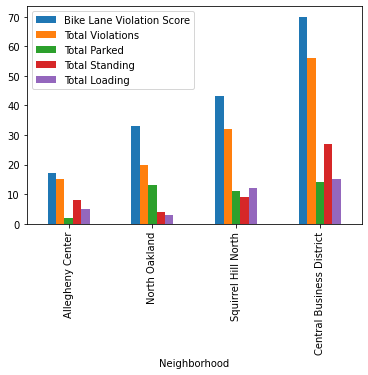

In [61]:
neighborhoodsSorted.plot.bar(x="Neighborhood", y=["Bike Lane Violation Score", "Total Violations", "Total Parked", "Total Standing", "Total Loading"])

Here we can see the surveyed neighboorhoods compared by their total violations and violation types